
## BUSINESS CASE | Satisfaction Surveys

### 🙌 Preparing the environment:

In [82]:
import numpy as np
import pandas as pd
#import sklearn

import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### APPENDIX | Functions

In [27]:
# CREATING WORD VISUALIZATIONS:

def visualize_wordcloud_dict_frequencies(dict_freqs, title, relative_scaling=0.5, max_words=100,
                                         background_color='black'):
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(width=900, height=500, max_words=max_words, relative_scaling=relative_scaling,
                          normalize_plurals=False, background_color=background_color).generate_from_frequencies(
        dict_freqs)
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


def get_word_frequencies(topic, vectorizer, top_words):
    word_indices = topic.argsort()[-top_words:]
    words = [vectorizer.get_feature_names()[i] for i in word_indices]
    frequencies = topic[word_indices]
    return dict(zip(words, frequencies))

### 💾 Loading the data:

In [99]:
# Importing the datasets:

path_to_file0 = 'data_for_topic_modeling.csv'
data = pd.read_csv(path_to_file0, encoding= "utf-8")

## 👓 Data Overview

In [11]:
print(data.shape)
print(data.columns)
data.head(2)

(284, 16)
Index(['Unnamed: 0', 'age', 'gender', 'job', 'experience', 'studies', 'income',
       'country', 'comments', 'expectations', 'workload', 'lecturer',
       'methodology', 'product', 'language', 'sentiment'],
      dtype='object')


,Unnamed: 0,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1


## Topic Modeling for English Comments

In [12]:
#CHECKPOINT:
data = data.dropna().drop(columns="Unnamed: 0")
en_data = data[data["language"] == 0]
en_data.head()

,age,gender,job,experience,studies,income,country,comments,expectations,workload,lecturer,methodology,product,language,sentiment
0,66,M,economics,9,master,26961,CO,hi know coming guys looks recent found way make,3,4,0,2,A,0,2
1,41,M,consultant,9,master,38792,UK,martin ostler gym pastures united kingdom wed sep,1,5,4,0,A,0,1
2,47,F,business administration,0,master,59526,BR,full immersion combine ft job learning eves we...,4,3,3,3,A,0,2
3,38,M,technician,3,PhD,29292,SA,sam cater kicks bootcamp providing personal in...,4,0,5,5,A,0,2
4,71,F,manager,8,master,66358,CO,complete go zero hero become expert,4,1,0,1,A,0,1


In [13]:
vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 0.01)
X_tfidf = vectorizer.fit_transform(en_data["comments"])
print(vectorizer.get_feature_names()[:100])

['academy', 'ads', 'agenda', 'almost', 'alumni', 'always', 'arrested', 'art', 'aspects', 'attended', 'august', 'available', 'back', 'bad', 'barely', 'barrys', 'become', 'beginner', 'believe', 'benefit', 'best', 'bluetooth', 'boot', 'bootcamp', 'bot', 'branding', 'broad', 'buck', 'business', 'calls', 'camp', 'campus', 'carbohydrates', 'career', 'cater', 'celebrate', 'changemakers', 'chart', 'chasing', 'check', 'class', 'classes', 'classrooms', 'click', 'code', 'coding', 'college', 'combine', 'coming', 'complete', 'concepts', 'content', 'contributes', 'core', 'coupon', 'course', 'courses', 'covered', 'create', 'crossing', 'crowdfunding', 'cuts', 'daily', 'day', 'deep', 'delighted', 'demand', 'demo', 'depending', 'design', 'desktop', 'development', 'differences', 'dom', 'dynamic', 'ecg', 'edd', 'education', 'emotional', 'engaging', 'entrepreneurs', 'event', 'eves', 'excited', 'excitement', 'exercises', 'exhaustion', 'expert', 'facebook', 'finally', 'finished', 'first', 'flying', 'found', 

In [14]:
X_tfidf.shape

(142, 307)

In [15]:
print(X_tfidf[0])

  (0, 167)	0.3250071850887734
  (0, 288)	0.3046735213733329
  (0, 93)	0.35223090382166916
  (0, 217)	0.35223090382166916
  (0, 161)	0.35223090382166916
  (0, 112)	0.3250071850887734
  (0, 48)	0.35223090382166916
  (0, 149)	0.2749211825599605
  (0, 120)	0.35223090382166916


In [16]:
print(data["comments"][:5])

0      hi know coming guys looks recent found way make
1    martin ostler gym pastures united kingdom wed sep
2    full immersion combine ft job learning eves we...
3    sam cater kicks bootcamp providing personal in...
4                  complete go zero hero become expert
Name: comments, dtype: object


In [17]:
print(X_tfidf[100])

  (0, 171)	0.5165221387362416
  (0, 229)	0.5165221387362416
  (0, 220)	0.5165221387362416
  (0, 289)	0.4467825428393729


## Latent Dirichlet Allocation (LDA)

In [18]:
# We wanted to tune both parameters below:
number_topics = 3
batch_size = 150


# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, 
                                doc_topic_prior=0.01, ##0.1  # by default = 1/number_topics
                                topic_word_prior=None,  ##0.1   # by default = 1/number_topics
                                learning_decay = 0.7,  # 0.7, 0.9
                                random_state = 23,
                                max_iter = 20,
                                batch_size=batch_size) 


lda.fit(X_tfidf)


LatentDirichletAllocation(batch_size=150, doc_topic_prior=0.01,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=20,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=23, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [19]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(X_tfidf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X_tfidf))

Log Likelihood:  -2238.8364508389127
Perplexity:  637.9465574148162


In [20]:
#lda.get_params
len(lda.components_)

3

In [21]:
# Extract word distributions for the optimized topics from LDA model
topic0 = lda.components_[0]
topic1 = lda.components_[1]
topic2 = lda.components_[2]

In [22]:
print(topic0.size)
print(topic1.size)
print(topic2.size)


307
307
307


In [23]:
topic1[:5]

array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 1.7475469 ])

In [24]:
vectorizer.get_feature_names()[1]

'ads'

In [25]:
topic2[:20]

array([1.01524877, 0.33333333, 0.33333333, 1.07791647, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       1.04940253, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [26]:
for index, topic in enumerate(lda.components_):
    print('Top 0 words for Topic {}', index)
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

Top 0 words for Topic {} 0
['incubation', 'hope', 'great', 'demand', 'exhaustion', 'time', 'know', 'virtual', 'become', 'zero', 'go', 'hero', 'expert', 'engaging', 'going', 'beginner', 'really', 'today', 'free', 'agenda', 'school', 'finally', 'excitement', 'course', 'complete', 'check', 'day', 'love', 'see', 'bootcamp']


Top 0 words for Topic {} 1
['via', 'art', 'good', 'insights', 'know', 'point', 'seats', 'miss', 'alumni', 'always', 'growth', 'changemakers', 'share', 'excited', 'celebrate', 'stories', 'read', 'cater', 'personal', 'sam', 'providing', 'stressing', 'kicks', 'concepts', 'career', 'pre', 'us', 'join', 'coding', 'bootcamp']


Top 0 words for Topic {} 2
['get', 'working', 'martin', 'python', 'php', 'sql', 'coupon', 'looks', 'coming', 'recent', 'hi', 'found', 'gym', 'kingdom', 'pastures', 'ostler', 'united', 'today', 'insights', 'welcome', 'bootcamp', 'delighted', 'licensing', 'web', 'sep', 'wed', 'massive', 'rest', 'semantic', 'udemy']




## Wordcloud visualizations

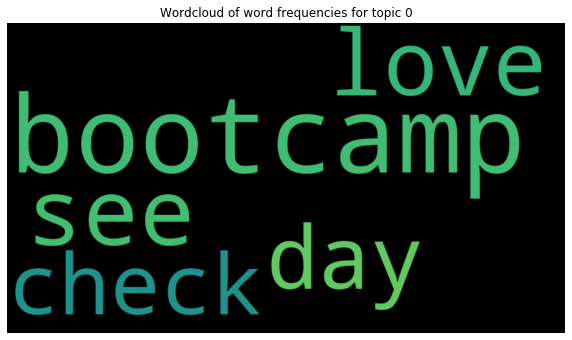

In [39]:
# Creating a dictionary between the words and the frequencies for the given topic
d_topic0 = get_word_frequencies(topic0, vectorizer, 5)
title="Wordcloud of word frequencies for topic 0"
visualize_wordcloud_dict_frequencies(d_topic0, title, relative_scaling=0.5, max_words=5, # changing max_words from 100 to 5
                                     background_color='black')

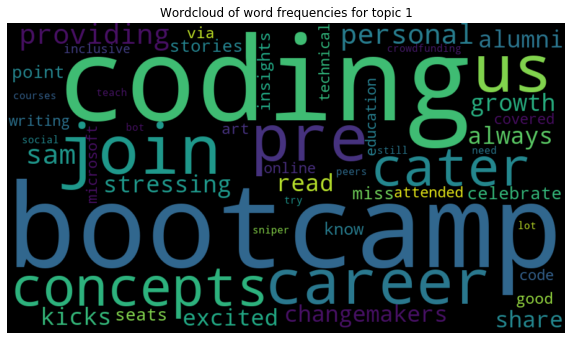

In [46]:
d_topic1 = get_word_frequencies(topic1, vectorizer, 50)
title="Wordcloud of word frequencies for topic 1"
visualize_wordcloud_dict_frequencies(d_topic1, title, relative_scaling=0.5, max_words=100,
                                background_color='black')

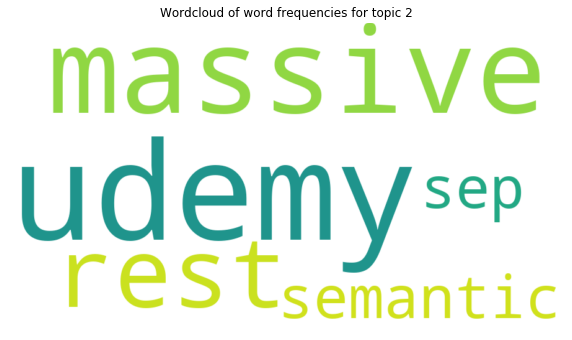

In [41]:
d_topic2 = get_word_frequencies(topic2, vectorizer, 50)
title="Wordcloud of word frequencies for topic 2"
visualize_wordcloud_dict_frequencies(d_topic2, title, relative_scaling=0.5, max_words=5, background_color='white') # changing max_words from 100 to 5 and background_color from "black" to "white"

## Classification with LDA topics

### TF-IDF vectors 
First, let's set a baseline which is using TF-IDF.

In [59]:
# Let's classify our observations with a topic model classification.
X = pd.DataFrame(X_tfidf.toarray())
y = en_data["gender"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print(X_train.shape)
print(X_test.shape)


(99, 307)
(43, 307)


In [60]:
start = datetime.now()
nb = MultinomialNB().fit(X_train, y_train)
elapsed = datetime.now() - start
print("Training time: {} seconds".format(elapsed.seconds))

Training time: 0 seconds


In [80]:
y_pred = nb.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)

print("accuracy: {0:0.2f} %".format(accuracy))
print(metrics.classification_report(y_test, y_pred))

accuracy: 0.53 %
              precision    recall  f1-score   support

           F       0.55      0.55      0.55        22
           M       0.52      0.52      0.52        21

    accuracy                           0.53        43
   macro avg       0.53      0.53      0.53        43
weighted avg       0.53      0.53      0.53        43



### This model is basically random since its accuracy is only 53%.
